In [4]:
# Requirements:
!pip install rtdl
!pip install libzero==0.0.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from typing import Any, Dict

import numpy as np
import rtdl
# rtdl Paper: https://arxiv.org/pdf/2106.11959.pdf
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

In [6]:
device = torch.device('cuda:0')
# Docs: https://yura52.github.io/delu/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)
print(device)

cuda:0


In [11]:
from google.colab import files
import pandas as pd
# Upload preprocessed_data.csv
uploaded = files.upload()

Saving preprocessed_data.csv to preprocessed_data.csv


In [ ]:
df = pd.read_csv('preprocessed_data.csv')
labels = df["DIED"]
df.drop("DIED",inplace=True,axis=1)

### Packages and helpers


In [17]:
# ====== Packages =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.frame import DataFrame
import seaborn as sns
import sklearn as sk
from prettytable import PrettyTable
from tqdm import tqdm

# ---- data manipulators ----
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

# ---- evaluation ------
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ====== Functions =======
def model_evaluation(y_true, y_pred):
    """Evaluate the ML model according to different metrics


    Parameters
    ----------

    y_true: Data structure containing the true labels of the examples
    y_pred: Data structure containing the prediction of the ML model


    Returns
    -------

    None


    """

    metric_table = PrettyTable()
    metric_table.field_names = ['Metric', 'Score']
    metric_table.add_row(['accuracy', accuracy_score(y_true, y_pred)])
    metric_table.add_row(['recall', recall_score(y_true, y_pred)])
    metric_table.add_row(['presicion', precision_score(y_true, y_pred)])
    metric_table.add_row(['f1 score', f1_score(y_true, y_pred)])
    metric_table.add_row(['f_beta score', fbeta_score(y_true, y_pred, beta=2)]) # recall is more important
    
    print(metric_table)

    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot()
    disp.ax_.set_xticklabels(['negative','positive'])
    disp.ax_.set_yticklabels(['negative','positive'])


def data_split(dataset:DataFrame ,n_splits=1, test_size=0.2, train_size=0.8):
    """ split the data into train and test (or train and validation)


    Parameters
    ----------

    dataset: A pandas Dataframe to split
    n_splits: (optional) An integer of number of splits
    test_size: (optional) An inegeger for the propotion of the test set
    train_size: (optional) An inegeger for the propotion of the train set


    Returns
    -------
    
    X_train, y_train, X_test, y_test


    """
    
    spliter = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, train_size=train_size)
    X = dataset.drop(dataset.columns[-1], axis=1)
    y = dataset[dataset.columns[-1]]
    train_index, test_index = next(spliter.split(X, y))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    return X_train, y_train, X_test, y_test
    

def up_down_sampling(X_train: DataFrame, y_train: DataFrame, ratio: int, up: bool):
    """up/down sample a dataset


    Parameters
    ----------

    X_train: A pandas DataFrame of the the train data without the labels
    y_train: A pandas DataFrame of the labels of the training data
    ratio: An integer for seting the proportion on the minority related to the majority
    up: A bool determine up sampling or down sampling
    

    Returns
    -------
    The upsampled X_train and y_train


    """
    
    X = pd.concat([X_train, y_train], axis=1)
    
    # Separate minority and majority classes (assume minority is labeled as 1)
    negative_samples = X[X[X.columns[-1]]==0]
    positive_samples = X[X[X.columns[-1]]==1]

    # Upsample the minotiry class
    if up:
        upsampled_positive_samples = resample(positive_samples, replace=True, n_samples=int(len(negative_samples)*ratio), random_state=27)
        X = pd.concat([negative_samples, upsampled_positive_samples])
    # Downsample the majority class
    else:
        downsampled_negative_samples = resample(negative_samples, replace=True, n_samples=int(len(positive_samples)*ratio), random_state=27)
        X = pd.concat([positive_samples, downsampled_negative_samples])

    X_train, y_train = X.drop(X.columns[-1], axis=1), X[X.columns[-1]]

    return X_train, y_train


## Data

* Note: Need to choose between original, upsampled and downsampled dataframes using the data_type variable

In [80]:
# d_train,label_train, d_test,label_test = data_split(df ,n_splits=1, test_size=0.4, train_size=0.6)
X_all_up, y_all_up = up_down_sampling(df.__deepcopy__(), labels.__deepcopy__(), ratio=1, up=True)
X_all_down, y_all_down = up_down_sampling(df.__deepcopy__(), labels.__deepcopy__(), ratio=1, up=False)

In [95]:
# !!! NOTE !!! The dataset splits, preprocessing and other details are
# significantly different from those used in the
# paper "Revisiting Deep Learning Models for Tabular Data",
# so the results will be different from the reported in the paper.

task_type = 'binclass'
assert task_type in ['binclass', 'multiclass', 'regression']

data_type = 'downsampled'
assert data_type in ['original', 'upsampled', 'downsampled']

if data_type == 'original':
  X_all = df.astype('float32')
  y_all = labels.astype('float32' if task_type == 'regression' else 'int64')

if data_type == 'upsampled':
  X_all = X_all_up.astype('float32')
  y_all = y_all_up.astype('float32' if task_type == 'regression' else 'int64')
if data_type == 'downsampled':
  X_all = X_all_down.astype('float32')
  y_all = y_all_down.astype('float32' if task_type == 'regression' else 'int64')

if task_type != 'regression':
    y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None

X = {}
y = {}
X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8
)
X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)

# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.transform(v), device=device)
    for k, v in X.items()
}

y = {k: torch.tensor(v, device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}

### Model
Carefully read the comments and uncomment the code for the model you want to test.

In [96]:
d_out = n_classes or 1

# model = rtdl.MLP.make_baseline(
#     d_in=X_all.shape[1],
#     d_layers=[128, 256, 128],
#     dropout=0.1,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

# model = rtdl.ResNet.make_baseline(
#     d_in=X_all.shape[1],
#     d_main=128,
#     d_intermidiate=256,
#     dropout_first=0.2,
#     dropout_second=0.0,
#     n_blocks=2,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

model = rtdl.FTTransformer.make_default(
    n_num_features=X_all.shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=d_out,
)

# === ABOUT CATEGORICAL FEATURES ===
# IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
# AND there are categorical features
# THEN you have to implement a wrapper that handles categorical features.
# The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
# ==================================
# 1. When you have both numerical and categorical features, you should prepare you data like this:
#    (X_num<float32>, X_cat<int64>) instead of X<float32>
#    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
#    use sklean.preprocessing.OrdinalEncoder to achieve this;
# 2. Prepare a list of so called "cardinalities":
#    cardinalities[i] = <the number of unique values of the i-th categorical feature>
# 3. See the commented example below and adapt it for your needs.
#
# class Model(nn.Module):
#     def __init__(
#         self,
#         n_num_features: int,
#         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
#         mlp_kwargs: Dict[str, Any],
#     ):
#         super().__init__()
#         self.cat_tokenizer = cat_tokenizer
#         self.model = rtdl.MLP.make_baseline(
#             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
#             **mlp_kwargs,
#         )
#
#     def forward(self, x_num, x_cat):
#         return self.model(
#             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
#         )
#
# model = Model(
#     # `None` means "Do not transform numerical features"
#     # `d_token` is the size of embedding for ONE categorical feature
#     X_num_all.shape[1],
#     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
#     mlp_kwargs,
# )
# Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

### Training

+--------------+---------------------+
|    Metric    |        Score        |
+--------------+---------------------+
|   accuracy   |  0.4949188378120311 |
|    recall    |  0.9811078006500542 |
|  presicion   | 0.49925915716205505 |
|   f1 score   |  0.6617643700472722 |
| f_beta score |  0.822369541280238  |
+--------------+---------------------+
Test score before training: 0.4949


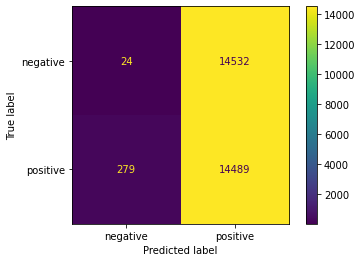

In [97]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part,oureval=False):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        if oureval:
          model_evaluation(target, prediction) # our evaluator
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/delu/reference/api/zero.data.IndexLoader.html
batch_size = 256
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/delu/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test",True):.4f}')

In [98]:
n_epochs = 25
prediction = []
y_true = []
report_frequency = len(X['train']) // batch_size // 5
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        predicted_batch = apply_model(x_batch).squeeze(1)
        loss = loss_fn(predicted_batch, y_batch)        
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    val_score = evaluate('val')
    test_score = evaluate('test')
    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        print("Early stopping due to progress fail")
        break

(epoch) 1 (batch) 0 (loss) 0.7176
(epoch) 1 (batch) 73 (loss) 0.2389
(epoch) 1 (batch) 146 (loss) 0.2858
(epoch) 1 (batch) 219 (loss) 0.2376
(epoch) 1 (batch) 292 (loss) 0.2152
(epoch) 1 (batch) 365 (loss) 0.2404
Epoch 001 | Validation score: 0.9144 | Test score: 0.9098 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.2309
(epoch) 2 (batch) 73 (loss) 0.2083
(epoch) 2 (batch) 146 (loss) 0.2923
(epoch) 2 (batch) 219 (loss) 0.2291
(epoch) 2 (batch) 292 (loss) 0.2105
(epoch) 2 (batch) 365 (loss) 0.2307
Epoch 002 | Validation score: 0.9138 | Test score: 0.9097
(epoch) 3 (batch) 0 (loss) 0.2295
(epoch) 3 (batch) 73 (loss) 0.2018
(epoch) 3 (batch) 146 (loss) 0.2915
(epoch) 3 (batch) 219 (loss) 0.2351
(epoch) 3 (batch) 292 (loss) 0.2144
(epoch) 3 (batch) 365 (loss) 0.2315
Epoch 003 | Validation score: 0.9141 | Test score: 0.9095
(epoch) 4 (batch) 0 (loss) 0.2276
(epoch) 4 (batch) 73 (loss) 0.2006
(epoch) 4 (batch) 146 (loss) 0.2975
(epoch) 4 (batch) 219 (loss) 0.2367
(epoch) 4 (batch) 29

In [ ]:
print(f'{data_type} data results {evaluate("test",True):.4f}')